In [ ]:
!pip -q install python-Levenshtein wandb kaggle

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 1.8MB 6.8MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 174kB 51.1MB/s 
     |████████████████████████████████| 133kB 37.3MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 


## Checking out GPU

Using Colab Pro

In [ ]:
!nvidia-smi

Thu May 20 07:28:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# OCR
This is just the training notebook. Will create an inference notebook later. Data generated from [this](https://www.kaggle.com/aditya08/ocr-create-word-level-data) notebook.

Extracting text of various sizes, shapes, and orientations from images is an essential problem in many contexts. To tackle this problem, one needs to accurately extract the text from images.

Basically, text extraction can be achieved into two steps, i.e., text detection and text recognition or by training a single model to achieve both text detection and recognition

**Text detection** helps identify the region in the image where the text is present. It takes in an image as an input, and the outputs bounding boxes.

**Text recognition** extracts the text from the input image using the bounding boxes obtained from the text detection model. It takes in an image and some bounding boxes as inputs and outputs some raw text.


> Here, since the text of interest are already focused upon, we need not worry about text detection & only need to solve the problem of text recognition

**Training on image dimensions (350, 800)**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from glob import glob
from itertools import chain
import random
from tqdm.notebook import tqdm
import time

import Levenshtein
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Activation, BatchNormalization, Bidirectional, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.models import Model

from wandb.keras import WandbCallback

In [ ]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
sns.set_style("darkgrid")

## Downloading Data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download & unzip training data
!kaggle datasets download -d aditya08/ocr-crnn-train-word-split-350-800
!unzip -q ocr-crnn-train-word-split-350-800.zip -d train

 96% 139M/145M [00:00<00:00, 207MB/s]
100% 145M/145M [00:00<00:00, 227MB/s]


In [ ]:
# Download & unzip test data
!kaggle datasets download -d aditya08/ocr-crnn-test-word-split-350-800
!unzip -q ocr-crnn-test-word-split-350-800.zip -d test

 52% 7.00M/13.4M [00:00<00:00, 71.8MB/s]
100% 13.4M/13.4M [00:00<00:00, 64.2MB/s]


## Setting up Wandb Tracking

In [ ]:
import wandb

In [ ]:
!wandb login $api_key

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Constants

This run is the same as - https://wandb.ai/adimyth/handwritten-ocr-crnn/runs/1kluvboh?workspace=user-adimyth except that the current run uses a deeper model. It looks as if setting higher `MAX_LENGTH` results into better Leaderboard Score

In [ ]:
params = dict(SEED = 42,
              IMG_HEIGHT = 350,
              IMG_WIDTH = 800,
              EPOCHS = 20,
              BATCH_SIZE = 16,
              MAX_LENGTH = 10,
              LR = 0.001,
              EXP_NAME = "handwritten-ocr-crnn-deeper")

In [ ]:
wandb.init(project=params["EXP_NAME"], config=params)
config = wandb.config
run_name = wandb.run.name

wandb: Currently logged in as: adimyth (use `wandb login --relogin` to force relogin)


## Utility Functions

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
seed_everything(config.SEED)

In [ ]:
def plot_hist(hist):
    plt.figure(figsize=(6, 6))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

In [ ]:
def plot_grid(dataset, h=4, w=4, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    for batch in dataset.shuffle(100).take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(h*w):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // h, i % w].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // h, i % w].axis("off")
            ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()

## Loading Data

In [ ]:
!ls train/images/images | wc

  54978   54978  538670


In [ ]:
train_df = pd.read_csv("train/train.csv")[["Path", "Labels"]]
train_df["Path"] = train_df["Path"].apply(lambda x: f"train/images/{x}")
train_df = train_df.dropna()
train_df.shape

(44795, 2)

In [ ]:
train_df.head()

,Path,Labels
0,train/images/images/0.png,ADULTEROUS
1,train/images/images/1.png,"WIFE,"
2,train/images/images/2.png,"EH,"
3,train/images/images/3.png,"ORSINI?"""
4,train/images/images/4.png,THIS


In [ ]:
train_df["Labels"].str.len().value_counts()

3     9390
2     7521
4     7202
5     5274
6     3860
7     3365
8     2419
1     1984
9     1682
10    1019
11     570
12     297
13     140
14      43
15      18
16       7
18       3
20       1
Name: Labels, dtype: int64

In [ ]:
train_df["Labels"].str.len().quantile(q=np.arange(0.90, 1.0, 0.01))

0.90     8.0
0.91     8.0
0.92     9.0
0.93     9.0
0.94     9.0
0.95     9.0
0.96    10.0
0.97    10.0
0.98    11.0
0.99    12.0
Name: Labels, dtype: float64

In [ ]:
train_df = train_df.loc[train_df["Labels"].str.len()<=config.MAX_LENGTH]
train_df.shape

(43716, 2)

In [ ]:
max_length = config.MAX_LENGTH

## Preprocessing

In [ ]:
characters = [']', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', 
              '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 
              'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
              'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 
              '[', '!']
print("Number of unique characters: ", len(characters))

Number of unique characters:  54


In [ ]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), invert=True, mask_token=None
)

In [ ]:
unk_token = "[UNK]"
mask_token = "]"

## Train-Valid Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df["Path"], train_df["Labels"], 
                                                      stratify=train_df["Labels"].str.len(),
                                                      random_state=config.SEED,
                                                      test_size=0.1)

In [ ]:
print(f"Training: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_valid.shape}, {y_valid.shape}")

Training: (39344,), (39344,)
Validation: (4372,), (4372,)


## Create *Tensorflow Dataset*

In [ ]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [config.IMG_HEIGHT, config.IMG_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .padded_batch(config.BATCH_SIZE) # pads to the smallest per-batch size that fits all elements
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

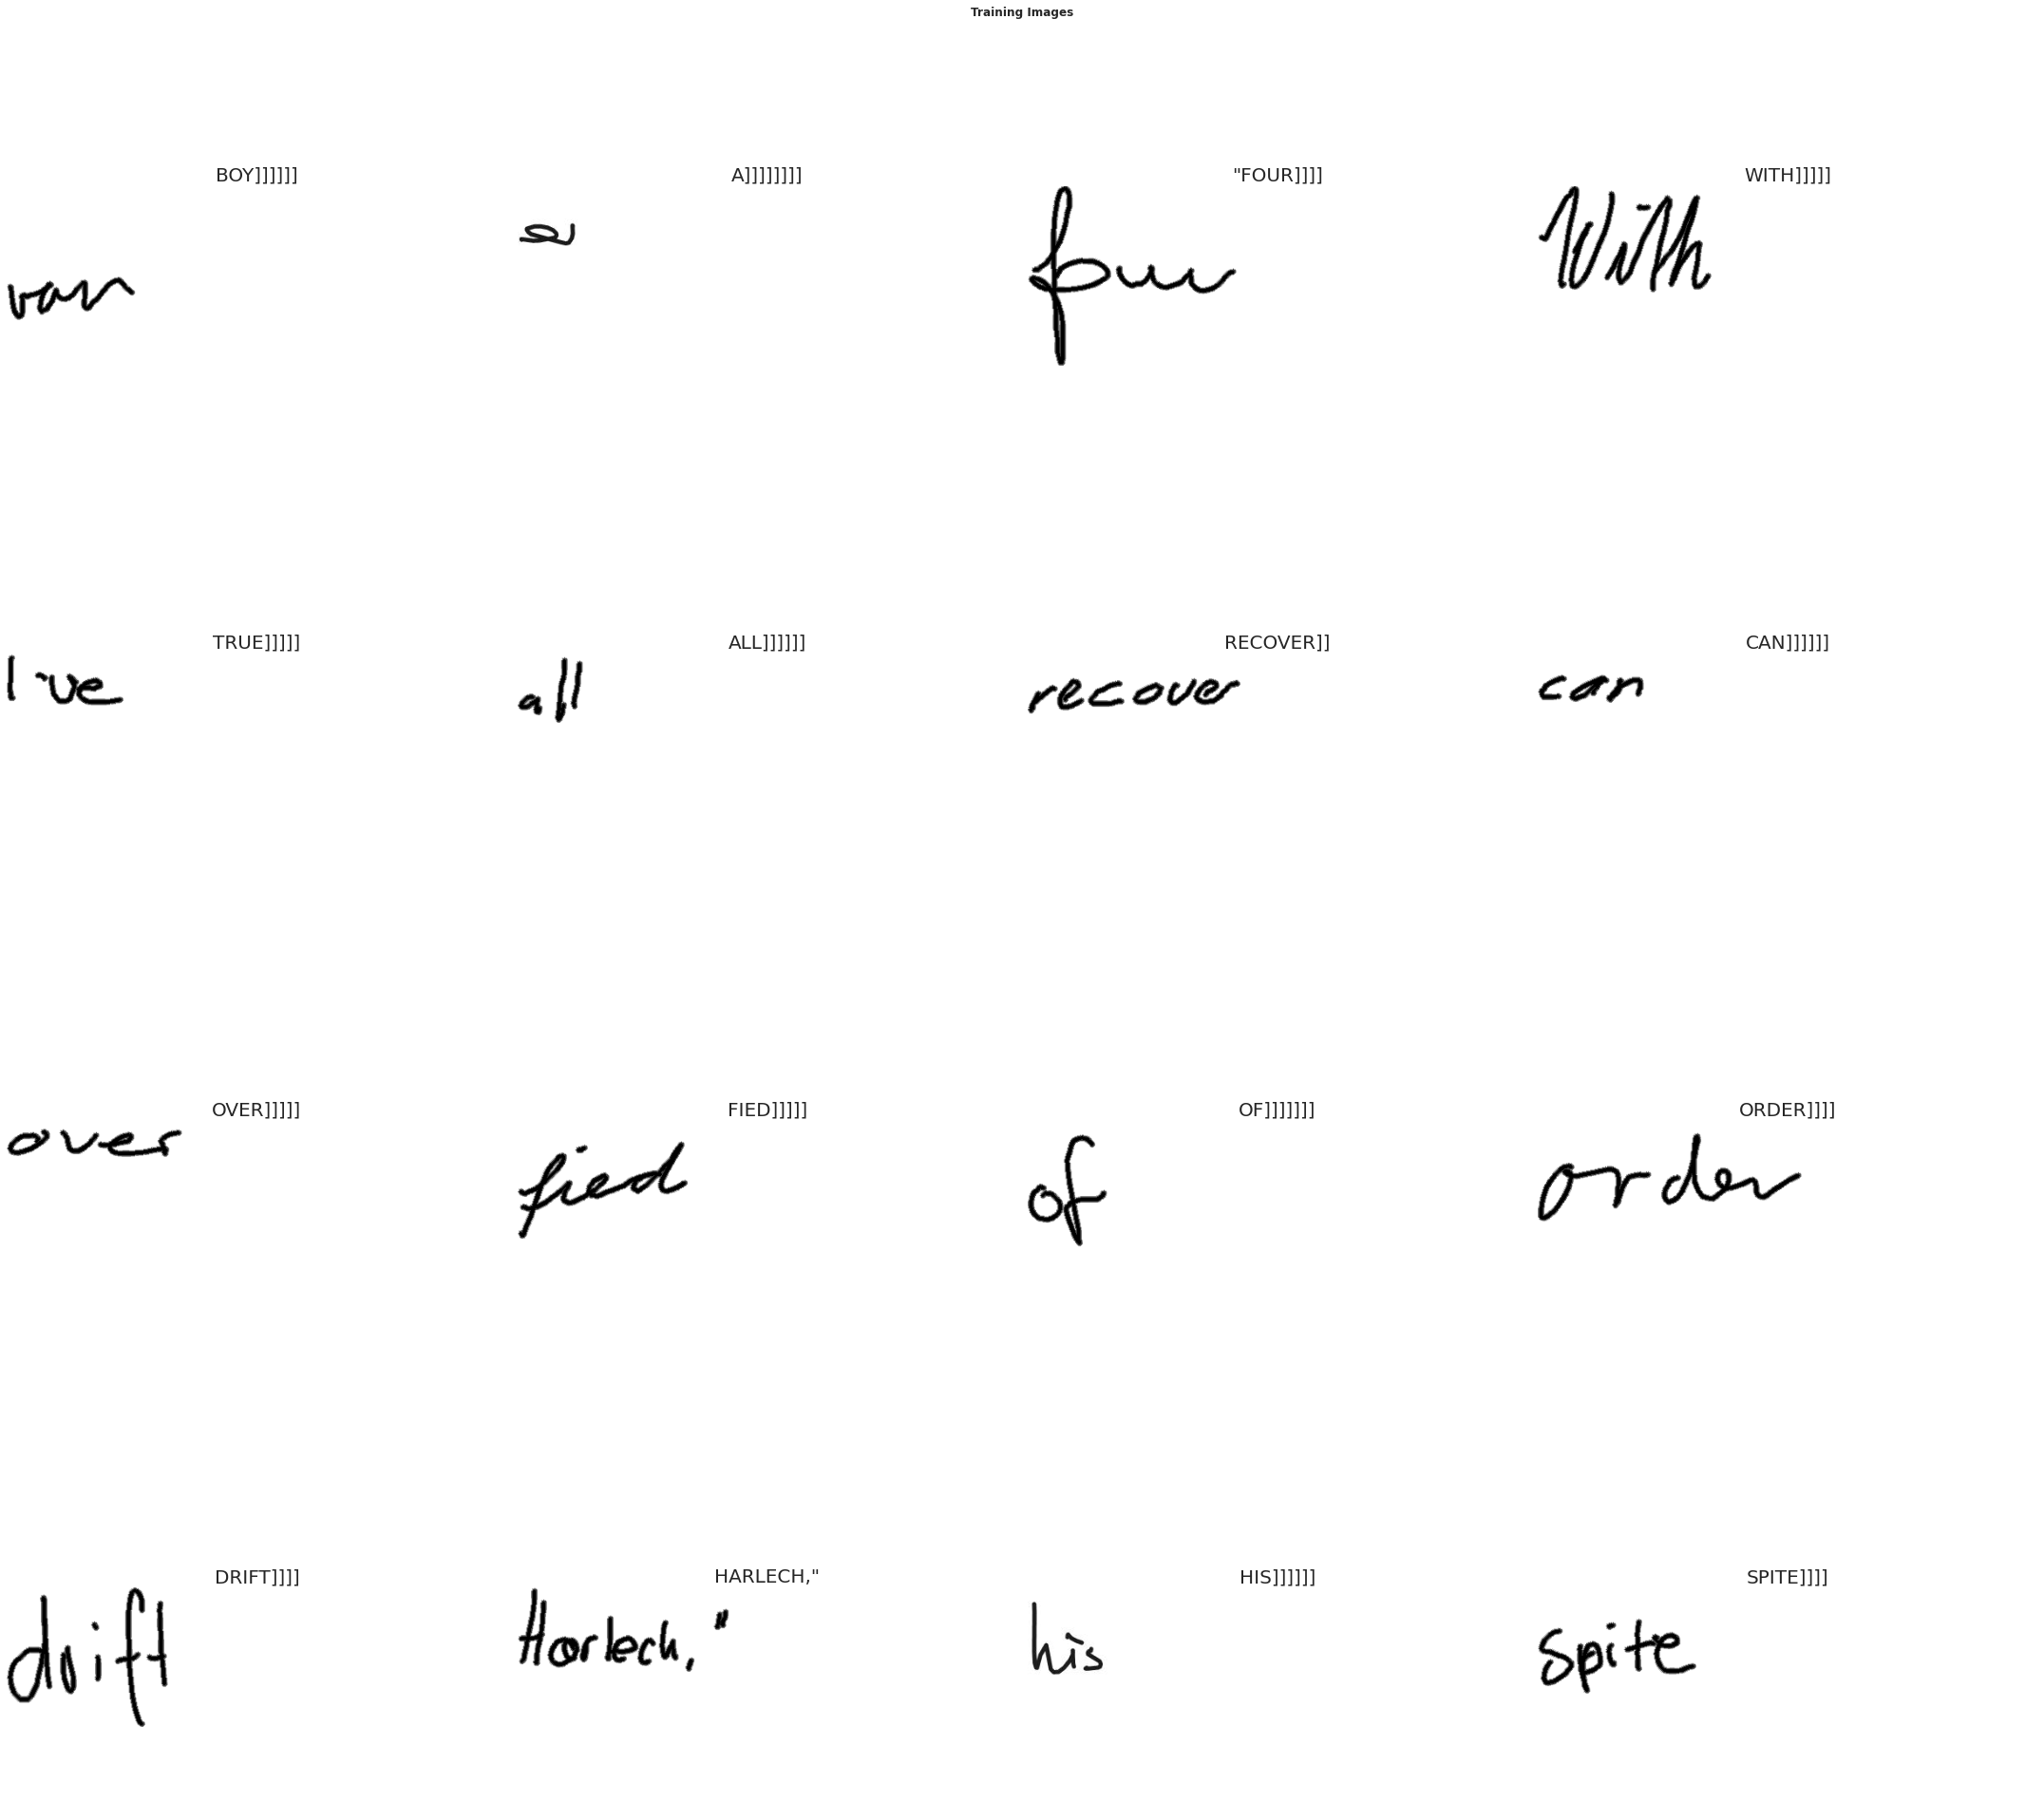

In [ ]:
plot_grid(train_dataset, title="Training Images")

In [ ]:
validation_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .padded_batch(config.BATCH_SIZE)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

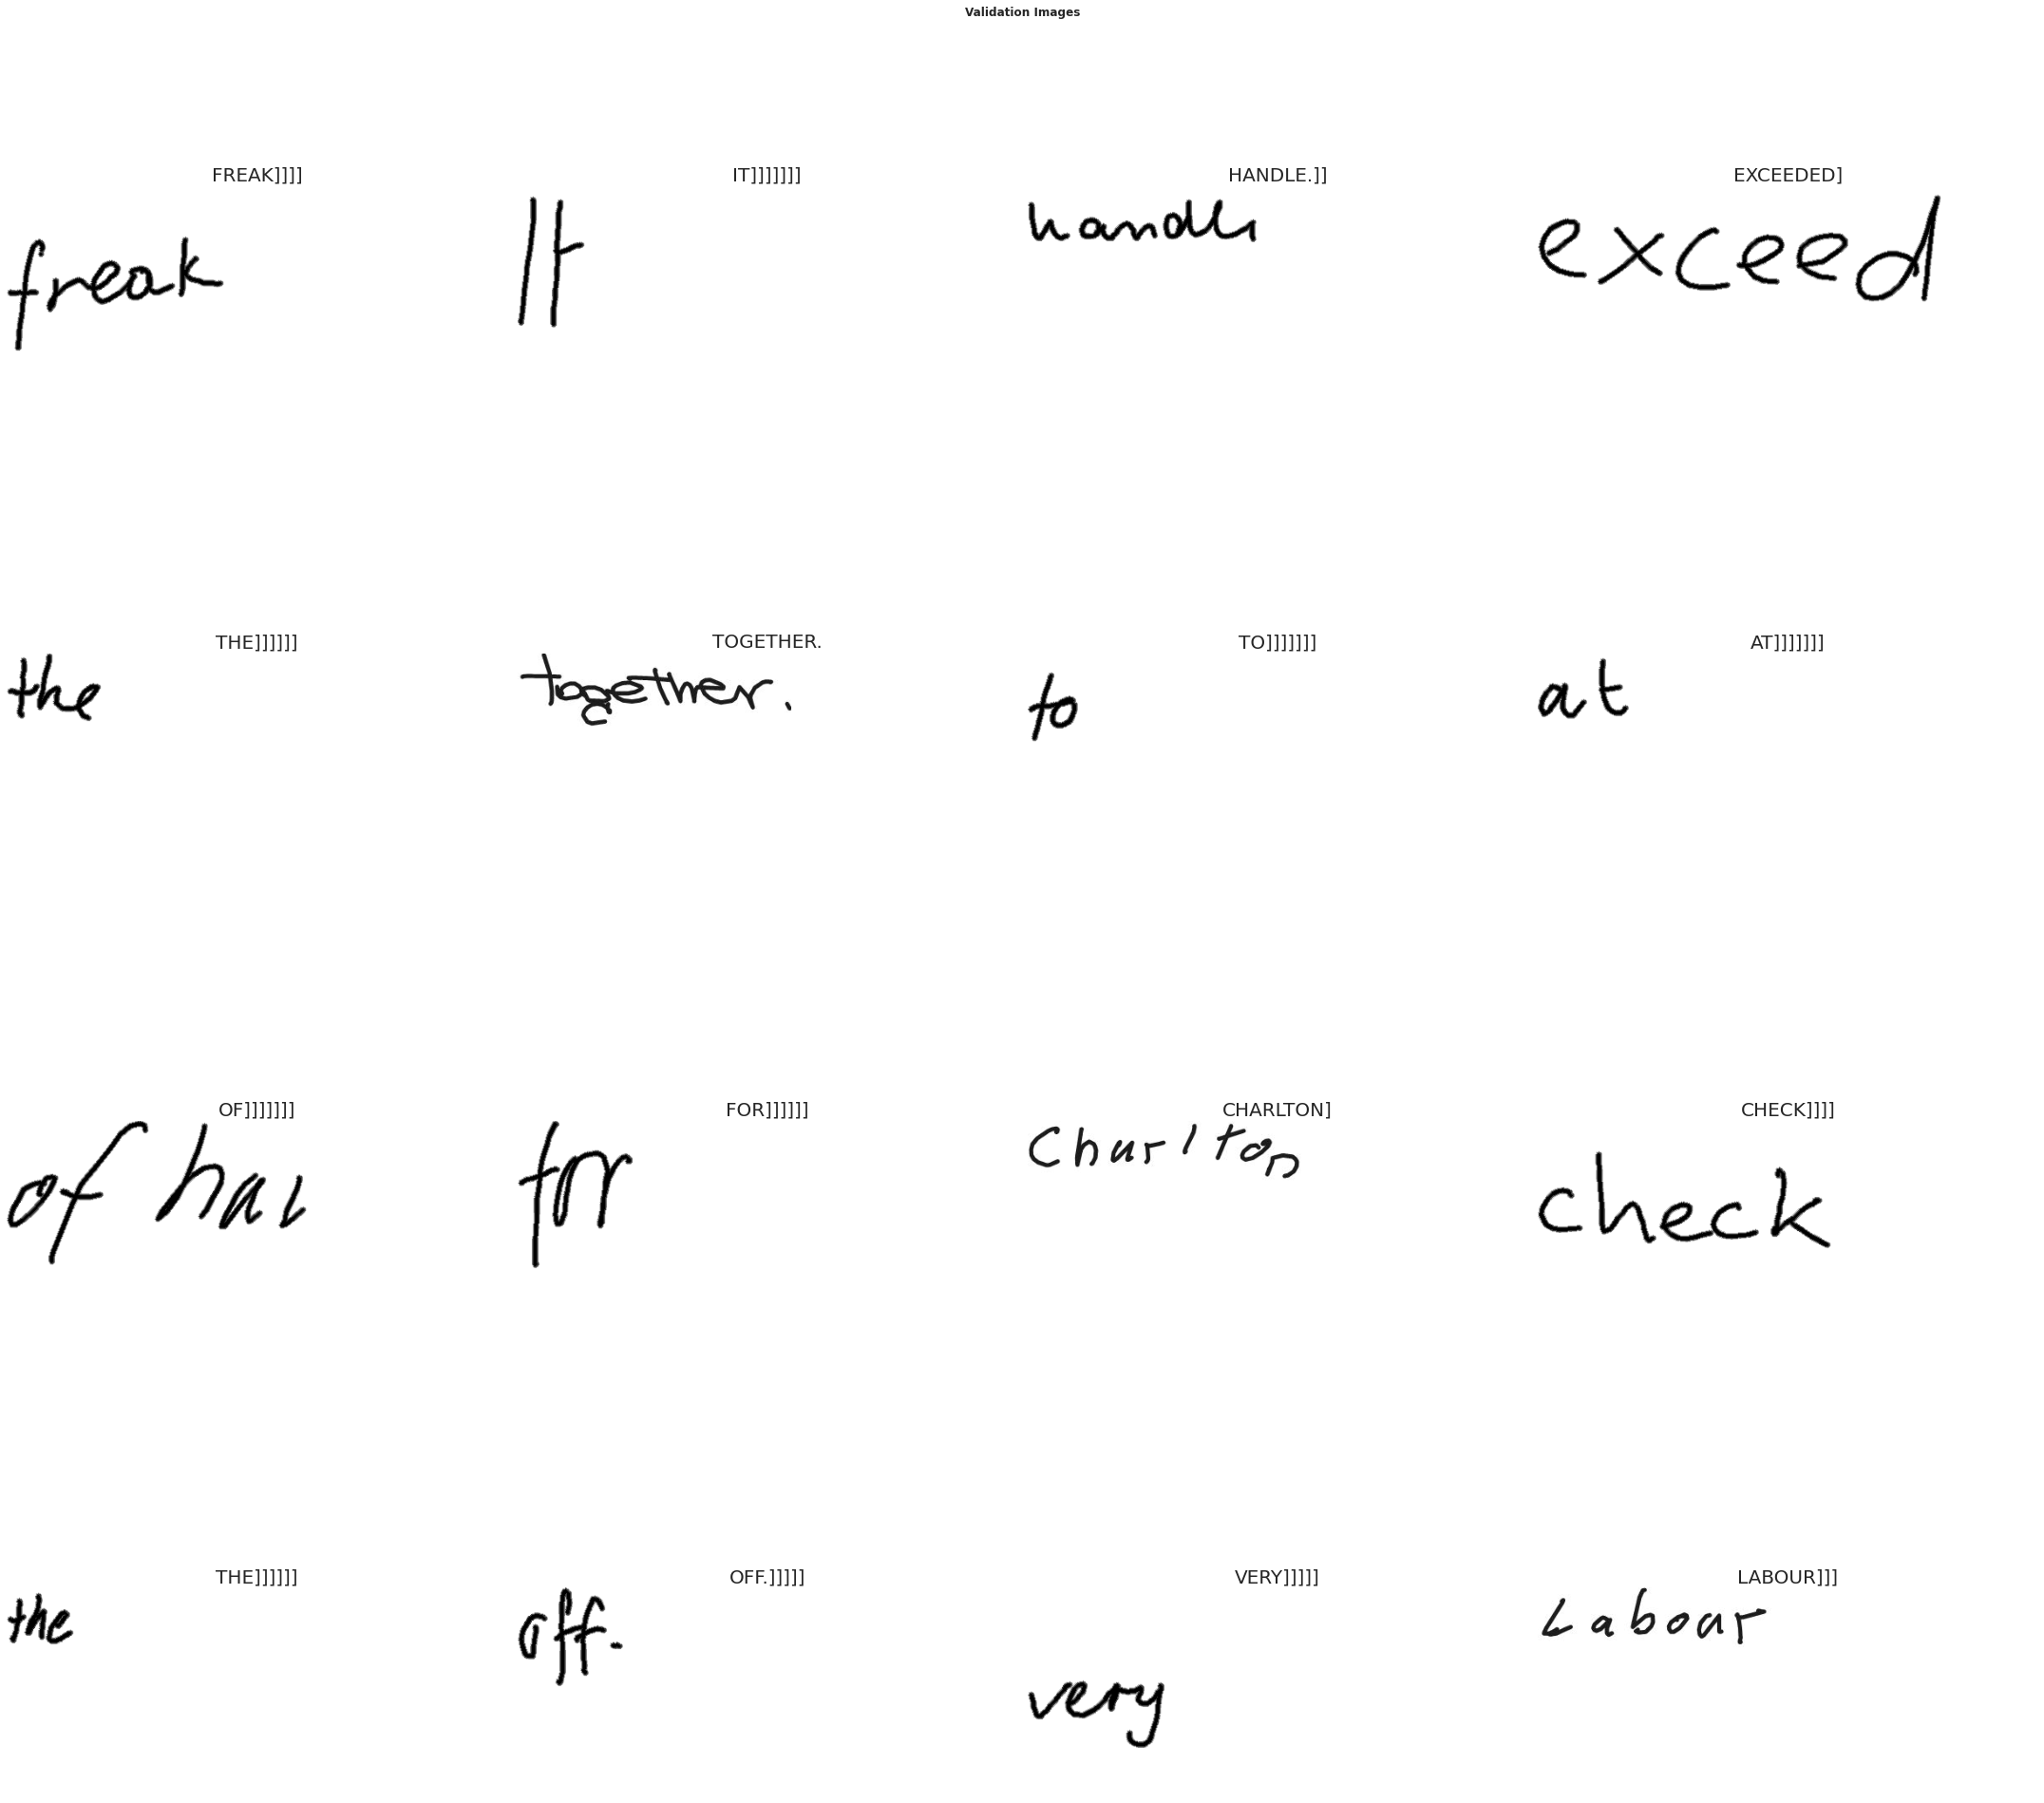

In [ ]:
plot_grid(validation_dataset, title="Validation Images")

## CRNN

In [ ]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [ ]:
def build_crnn_model():
    # Inputs to the model
    input_img = Input(
        shape=(config.IMG_WIDTH, config.IMG_HEIGHT, 1), name="image", dtype="float32"
    )
    labels = Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv_1")(input_img)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_2")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_3")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_4")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_5")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_6")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_7")(x)
    x = BatchNormalization(name="bn_3")(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((config.IMG_WIDTH // 4), (config.IMG_HEIGHT // 4) * 256)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(128, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=config.LR)
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

## Save Model Checkpoints to Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Training

In [ ]:
model = build_crnn_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 600, 250, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 600, 250, 32) 320         image[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 600, 250, 64) 18496       conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 600, 250, 128 73856       conv_2[0][0]                     
_______________________________________________________________________________________

In [ ]:
early_stopping_patience = 4
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

checkpoint_filepath = f"/content/gdrive/My Drive/HandwrittenOCR/{run_name}/model_checkpoint"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="val_loss",
    mode="min",
    save_best_only=True)

wandbcallback = WandbCallback(monitor="val_loss")

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=config.EPOCHS,
    callbacks=[early_stopping, model_checkpoint_callback, wandbcallback]
)

Epoch 1/25
2459/2459 [==============================] - 720s 287ms/step - loss: 20.6672 - val_loss: 73.3575


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 2/25
2459/2459 [==============================] - 701s 285ms/step - loss: 9.4034 - val_loss: 8.7566


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 3/25
2459/2459 [==============================] - 702s 285ms/step - loss: 7.4516 - val_loss: 49.7676
Epoch 4/25
2459/2459 [==============================] - 701s 285ms/step - loss: 6.8296 - val_loss: 32.7439
Epoch 5/25
2459/2459 [==============================] - 701s 285ms/step - loss: 6.4606 - val_loss: 6.5680


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 6/25
2459/2459 [==============================] - 701s 285ms/step - loss: 6.2434 - val_loss: 11.8113
Epoch 7/25
2459/2459 [==============================] - 701s 285ms/step - loss: 6.0408 - val_loss: 6.4860


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 8/25
2459/2459 [==============================] - 700s 285ms/step - loss: 5.8800 - val_loss: 6.2646


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 9/25
2459/2459 [==============================] - 703s 286ms/step - loss: 5.8139 - val_loss: 5.5560


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/HandwrittenOCR/astral-yogurt-6/model_checkpoint/assets


Epoch 10/25
2459/2459 [==============================] - 706s 287ms/step - loss: 5.6597 - val_loss: 5.8119
Epoch 11/25
2459/2459 [==============================] - 703s 286ms/step - loss: 5.6125 - val_loss: 6.3996
Epoch 12/25
2459/2459 [==============================] - 705s 287ms/step - loss: 5.5551 - val_loss: 18.0894
Epoch 13/25
2459/2459 [==============================] - 704s 286ms/step - loss: 5.4676 - val_loss: 24.8185
Epoch 14/25
2459/2459 [==============================] - 702s 285ms/step - loss: 5.4544 - val_loss: 27.6066


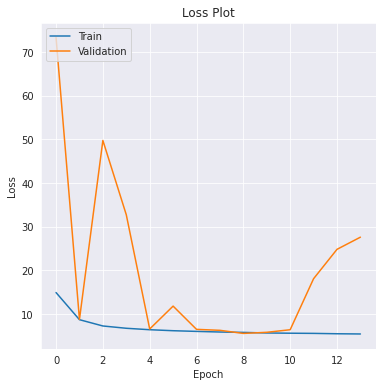

In [ ]:
plot_hist(history)

## Inference
Always load the model to use the best save weights

In [ ]:
best_model = tf.keras.models.load_model(checkpoint_filepath)

In [ ]:
prediction_model = tf.keras.models.Model(
    best_model.get_layer(name="image").input, best_model.get_layer(name="dense2").output
)

In [ ]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
def get_all_preds(dataset):
    """
    Utility function that returns both model prediction & actual labels
    """
    decoded_text, actuals_text = [], []
    for batch in tqdm(dataset):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)
        # handling UNK & MASK token
        pred_texts = [x.replace(unk_token, '').replace(mask_token, '') for x in pred_texts]

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label.replace(unk_token, '').replace(mask_token, ''))

        decoded_text.append(pred_texts)
        actuals_text.append(orig_texts)

    # flatten 2D list
    decoded_text = list(chain.from_iterable(decoded_text))
    actuals_text = list(chain.from_iterable(actuals_text))
    return decoded_text, actuals_text

## Validation Data Evaluation

### Random Plots

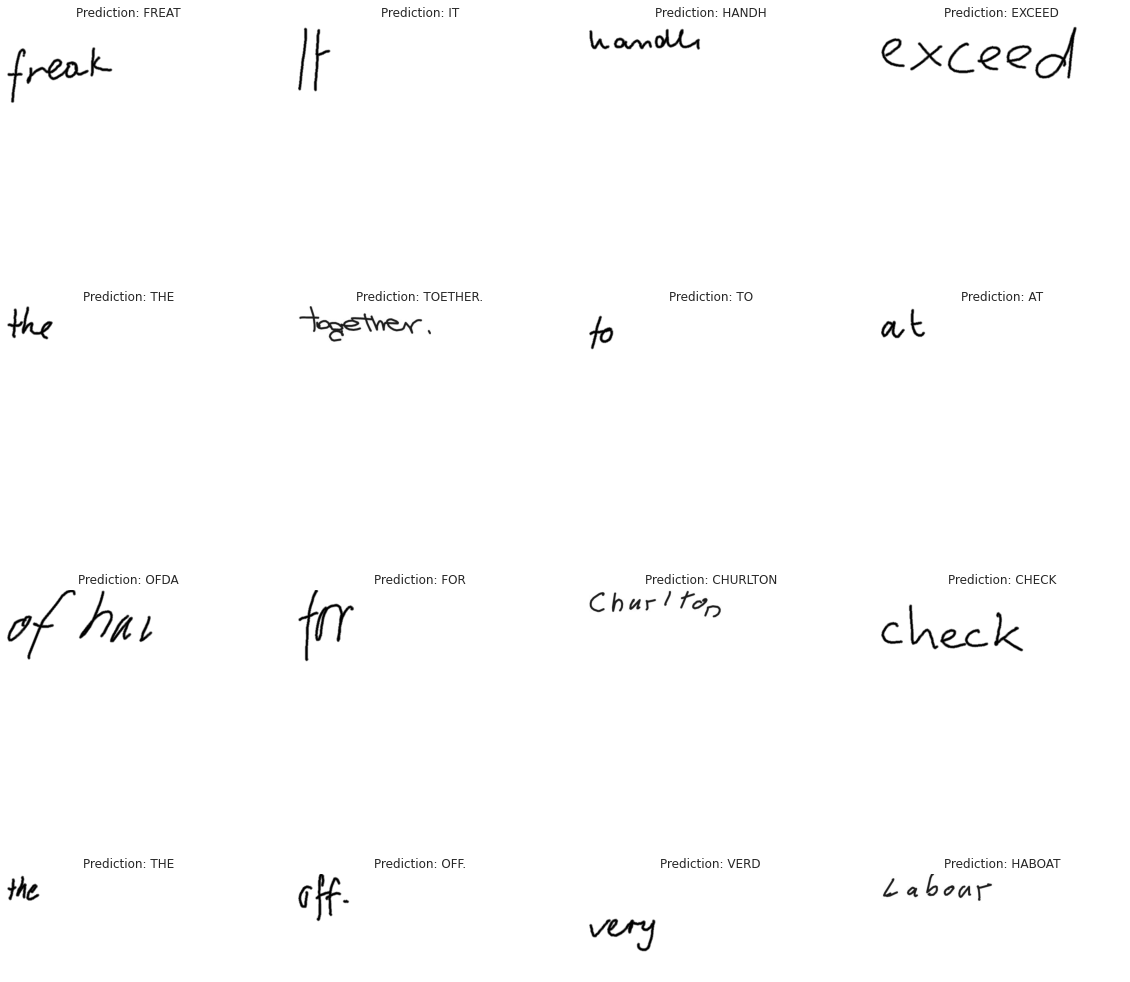

In [ ]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        # handling UNK & MASK tokens
        title = f"Prediction: {pred_texts[i].replace(unk_token, '').replace(mask_token, '')}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
wandb.log({"Validation Predictions": wandb.Image(fig)})

In [ ]:
decoded_text, actuals_text = get_all_preds(validation_dataset)

### Accuracy

In [ ]:
valid_acc = accuracy_score(actuals_text, decoded_text)
print(f"Validation Data Accuracy: {valid_acc:.5f}")
wandb.log({"Validation Accuracy": valid_acc})

Validation Data Accuracy: 0.16878


### Levenhstein Distance

In [ ]:
def get_score(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        score = Levenshtein.distance(true, pred)
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score

In [ ]:
val_levenhstein = get_score(actuals_text, decoded_text)
print(f"Mean Validation Levenshtein Distance: {val_levenhstein:.5f}")
wandb.log({"Mean Validation Levenshtein Distance": val_levenhstein})

Mean Validation Levenshtein Distance - Greedy: 0.89661
Mean Validation Levenshtein Distance - Beam Search (10): 0.92864


## Training Data Evaluation

### Random Plots

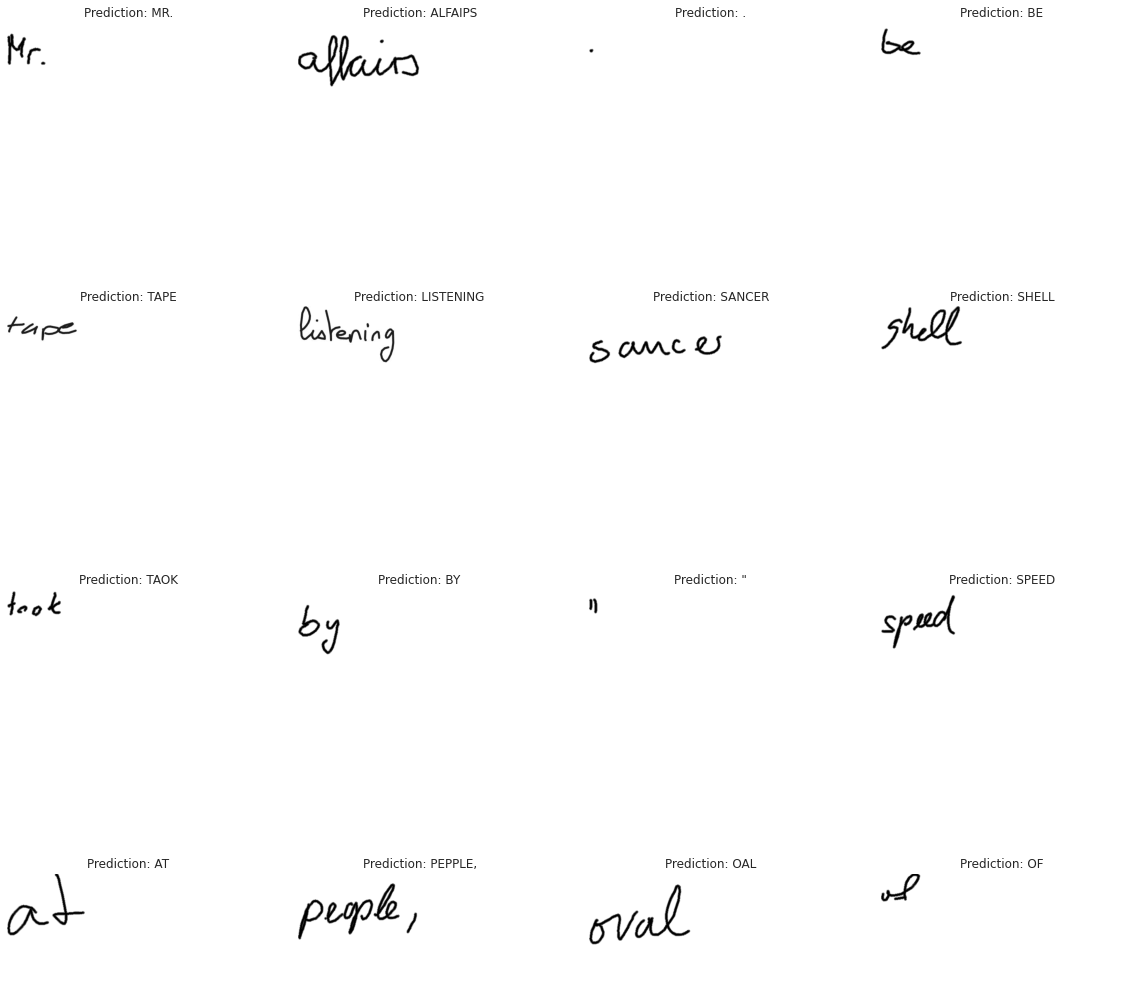

In [ ]:
#  Let's check results on some training samples
for batch in train_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    fig, ax = plt.subplots(4, 4, figsize=(20, 20))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        # handling UNK & MASK tokens
        title = f"Prediction: {pred_texts[i].replace(unk_token, '').replace(mask_token, '')}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [ ]:
wandb.log({"Training Predictions": wandb.Image(fig)})

In [ ]:
decoded_text, actuals_text = get_all_preds(train_dataset)

### Accuracy

In [ ]:
train_acc = accuracy_score(actuals_text, decoded_text)
print(f"Training Accuracy: {train_acc:.5f}")
wandb.log({"Training Accuracy": train_acc})

Training Accuracy - Greedy: 0.55317
Training Accuracy - Beam Search (10): 0.52702


### Levenshtein Distance

In [ ]:
train_levenhstein = get_score(actuals_text, decoded_text)
print(f"Mean Training Levenshtein Distance: {train_levenhstein:.5f}")
wandb.log({"Mean Training Levenshtein Distance": train_levenhstein})

Mean Training Levenshtein Distance - Greedy: 0.88799
Mean Training Levenshtein Distance - Beam Search (10): 0.91953


## Test Inference

Generating submission file for test data

In [ ]:
import ast
import cv2

In [ ]:
test_df = pd.read_csv("test/test_csv.csv")
test_images = glob("test/test_images/test_images/*.png")

In [ ]:
def encode_single_sample(img_path):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [config.IMG_HEIGHT, config.IMG_WIDTH])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Return img
    return img

In [ ]:
def get_all_preds(test_df):
    labels = []
    for idx, row in tqdm(test_df.iterrows()):
        row_pred = []
        image_splits = [f"test/test_images/test_images/{x}.png" for x in ast.literal_eval(row["Splits"])]
        for img_split in image_splits:
            processed_split = np.expand_dims(encode_single_sample(img_split), axis=0)
            split_pred = prediction_model.predict(processed_split)
            split_pred = decode_batch_predictions(split_pred)[0]
            # handling UNK & MASK token
            split_pred = split_pred.replace(unk_token, '').replace(mask_token, '')
            row_pred.append(split_pred)
        labels.append(" ".join(row_pred))
    return labels

In [ ]:
predictions = get_all_preds(test_df)

In [ ]:
submission_df = pd.DataFrame.from_dict({"imageName": test_df["Path"].apply(lambda x: x.split("/")[-1]), 
                                        "prediction": predictions})

In [ ]:
submission_df.head()

,imageName,prediction
0,r07-568z-05.tif,WRITING 'A I L3SAD ABCUT IM
1,r07-568z-07.tif,"AT MAST,TO THOL TE WUAS T.F I"
2,r08-612z-05.tif,'T EMAINED THUS FR 'A WHOLE TUMER.
3,p07-917z-05.tif,IDEA YIOU W AA WEEALTHYY
4,r02-091z-01.tif,TTHE REIN REWN IILTO


### Random Plots (Word Level)

In [ ]:
def plot_grid_word_level(test_images, h=4, w=4, title=""):
    f, ax = plt.subplots(h, w, figsize=(30, 30))
    images = np.random.choice(test_images, size=h*w)
    for i in range(h*w):
        img = cv2.imread(images[i])
        # make prediction
        processed_split = np.expand_dims(encode_single_sample(images[i]), axis=0)
        label = prediction_model.predict(processed_split)
        label = decode_batch_predictions(label)[0]
        label = label.replace(unk_token, '').replace(mask_token, '')
        ax[i // h, i % w].imshow(img)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title, fontsize="large", fontweight="extra bold")
    plt.show()
    # log pred image samples into wandb
    wandb.log({title: wandb.Image(f)})

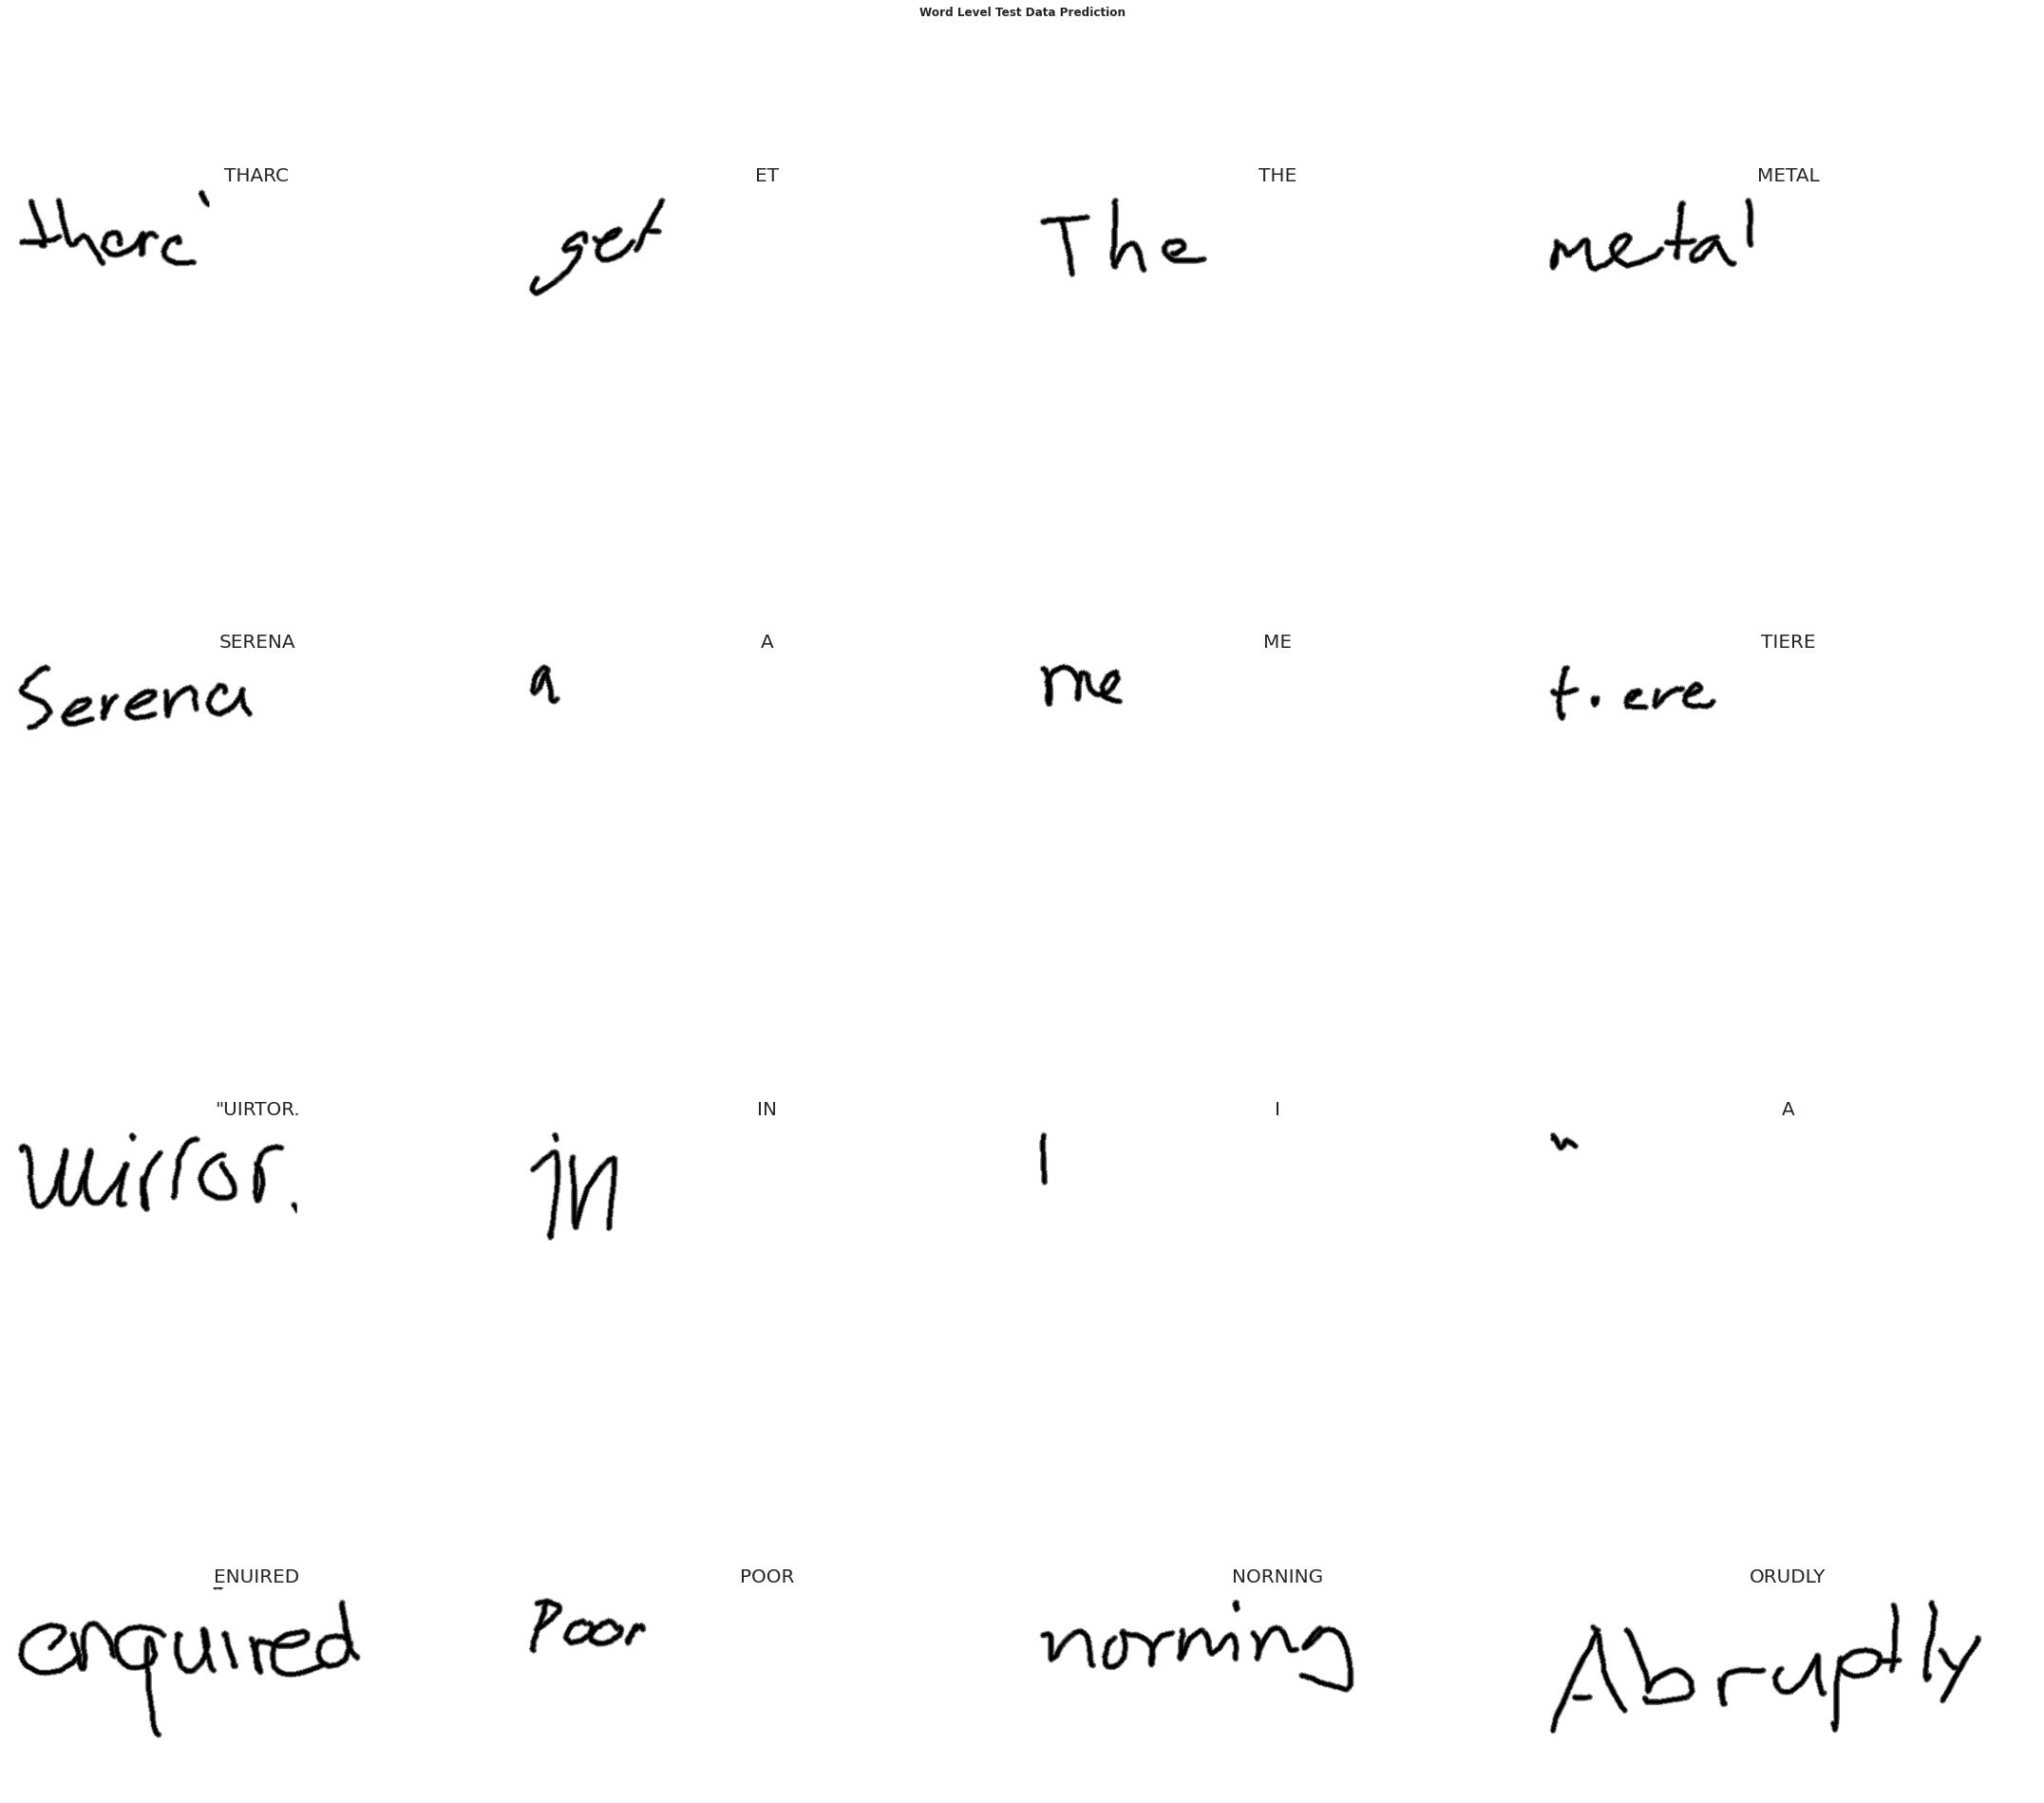

In [ ]:
plot_grid_word_level(test_images, title="Word Level Test Data Prediction")

### Random Plots (Sentence Level)

In [ ]:
!kaggle competitions download -c arya-hw-lines

  0% 0.00/36.2k [00:00<?, ?B/s]
100% 36.2k/36.2k [00:00<00:00, 34.8MB/s]
  0% 0.00/44.7k [00:00<?, ?B/s]
100% 44.7k/44.7k [00:00<00:00, 45.8MB/s]
  0% 0.00/27.7k [00:00<?, ?B/s]
100% 27.7k/27.7k [00:00<00:00, 27.8MB/s]
  0% 0.00/36.7k [00:00<?, ?B/s]
100% 36.7k/36.7k [00:00<00:00, 32.9MB/s]
  0% 0.00/19.9k [00:00<?, ?B/s]
100% 19.9k/19.9k [00:00<00:00, 19.8MB/s]
  0% 0.00/47.5k [00:00<?, ?B/s]
100% 47.5k/47.5k [00:00<00:00, 48.9MB/s]
  0% 0.00/32.6k [00:00<?, ?B/s]
100% 32.6k/32.6k [00:00<00:00, 29.9MB/s]
  0% 0.00/39.8k [00:00<?, ?B/s]
100% 39.8k/39.8k [00:00<00:00, 39.4MB/s]
  0% 0.00/39.0k [00:00<?, ?B/s]
100% 39.0k/39.0k [00:00<00:00, 35.5MB/s]
  0% 0.00/41.6k [00:00<?, ?B/s]
100% 41.6k/41.6k [00:00<00:00, 42.7MB/s]
  0% 0.00/30.5k [00:00<?, ?B/s]
100% 30.5k/30.5k [00:00<00:00, 31.8MB/s]
  0% 0.00/22.8k [00:00<?, ?B/s]
100% 22.8k/22.8k [00:00<00:00, 23.4MB/s]
  0% 0.00/27.4k [00:00<?, ?B/s]
100% 27.4k/27.4k [00:00<00:00, 28.7MB/s]
  0% 0.00/32.0k [00:00<?, ?B/s]
100% 32.0k/32.0k [0

In [ ]:
files = list(glob("*.tif"))
overlap = submission_df.loc[submission_df["imageName"].isin(files)]

In [ ]:
def plot_grid(files, labels=None, h=3, w=3, title=""):
    if not labels:
        labels = [""]*len(files)
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for idx, (path, label) in enumerate(random.choices(list(zip(files, labels)), k=h*w)):
        image = cv2.imread(path, 0)
        ax[idx // h, idx % w].imshow(image)
        ax[idx // h, idx % w].axis("off")
        ax[idx // h, idx % w].set_title(f"{path.split('/')[-1]} - {label}")
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    wandb.log({title: wandb.Image(f)})

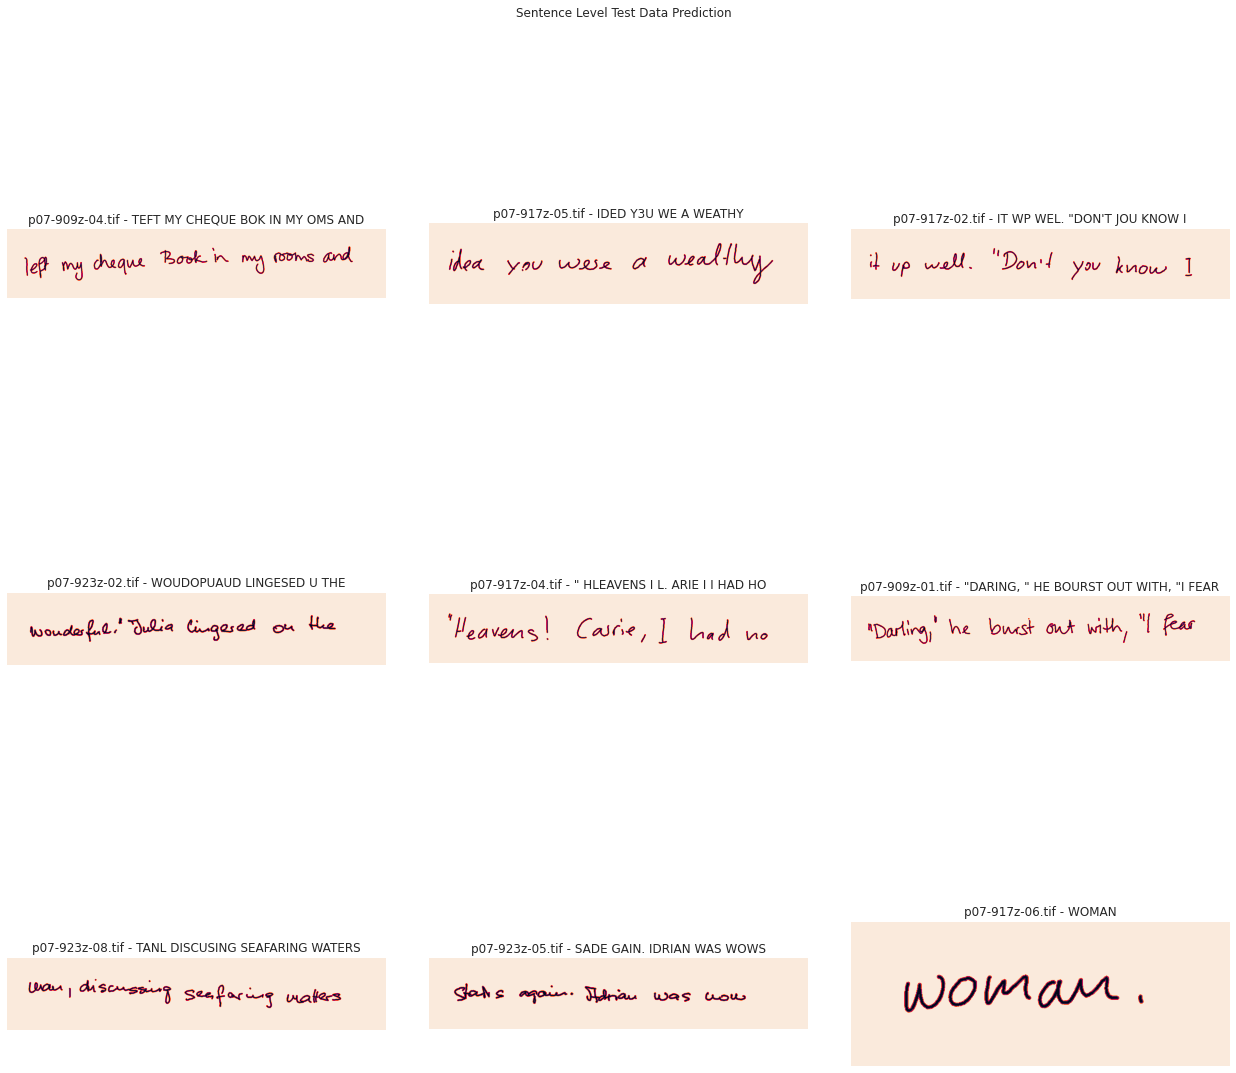

In [ ]:
plot_grid(overlap["imageName"].tolist(), overlap["prediction"].tolist(), title="Sentence Level Test Data Prediction")

### Making Submission

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
submission_df.to_csv(f"/content/gdrive/My Drive/HandwrittenOCR/{run_name}/submission.csv")

In [ ]:
!kaggle competitions submit -c arya-hw-lines -f submission.csv -m "Deeper CRNN - 250x600 - P100 - 15 Epochs. 10 Characters"

![](https://imgur.com/IE0ybJE.png)